# Monte Carlo Simulation

* Perform a Monte Carlo Simulation on the future performance of AMZN stock price to predict the future price of Seattle housing price by using linear regression

* 5-year projection with 500 iterations based on 5 years of historical AMZN stock data

### Import libraries and dependencies

In [1]:
import os
import pandas as pd
from pathlib import Path
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
%matplotlib inline

**Load .env enviroment variables**

*The environment variables include the API and secret keys required for calling the Alpaca trade api.*

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

**Set Alpaca API key and secret**

*Set the alpaca_api_key and alpaca_secret_key from the environment variables using os.getenv function.*

In [3]:
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [4]:
def days_to_trading_days(days):
    return round(days * 252 / 365)

def trading_days_to_days(trading_days):
    return round(trading_days * 365 / 252)

In [5]:
def get_barset_amzn(start_date, end_date):
    """
    Gets alpaca barset for AMZN with 1D timeframe for the given dates
    and returns the data in a pandas dataframe.
    
    If the num of days is greater than 1000, it makes more than one api
    call and combines the responses in a single dataframe.
    """
    # Initialize a variable `df` to store the final dataframe.
    df = None;
    
    # Calculate the num of days in the given start and end dates
    days = (end_date - start_date).days
    
    # Convert num of days into num of trading days
    trading_days = days_to_trading_days(days)
    
    # Calculate the num of calls to make
    # e.g. for 1500 trading days we need to make at least 2 api calls
    # trading_days = 1500, round(trading_days/1000) = 1, num_api_calls = 1 + 1 = 2
    num_api_calls = 1 + round(trading_days/1000)
    
    # 252 trading days = 365 normal days
    # 1000 trading days = 1000 * 365 / 252 normal days
    days_per_1k_trading_days = trading_days_to_days(1000)
    
    start = start_date 
    for i in range(num_api_calls):
        end = start + pd.DateOffset(days_per_1k_trading_days)
        print(str(start)+" to "+str(end))
        tmp_df = api.get_barset(
            "AMZN",
            "1D",
            start = start.isoformat(),
            end = end.isoformat() ,
            limit = 1000
        ).df
        start = end       
        if df is None:
            df = tmp_df
        else:
            df = pd.concat([df, tmp_df])
                   
    return df

In [6]:
start_date = pd.Timestamp("2016-01-01", tz="America/New_York")
end_date = pd.Timestamp("2021-04-08", tz="America/New_York")
df = get_barset_amzn(start_date, end_date)

2016-01-01 00:00:00-05:00 to 2019-12-19 00:00:00-05:00
2019-12-19 00:00:00-05:00 to 2023-12-06 00:00:00-05:00


In [7]:
df

AMZN                                     
                              open      high      low    close   volume
time                                                                   
2016-01-04 00:00:00-05:00   656.29   657.715   627.51   636.73  6683946
2016-01-05 00:00:00-05:00   646.86   646.910   627.65   633.79  4288182
2016-01-06 00:00:00-05:00   622.00   639.790   620.31   632.81  3865144
2016-01-07 00:00:00-05:00   622.38   630.000   605.21   607.84  5235612
2016-01-08 00:00:00-05:00   618.86   624.140   606.00   607.23  4005059
...                            ...       ...      ...      ...      ...
2021-04-12 00:00:00-04:00  3358.43  3395.040  3351.15  3379.39  2730363
2021-04-13 00:00:00-04:00  3402.00  3432.000  3395.63  3400.00  2966542
2021-04-14 00:00:00-04:00  3403.63  3404.130  3326.00  3334.89  2606119
2021-04-15 00:00:00-04:00  3371.00  3397.000  3352.00  3378.89  2645485
2021-04-16 00:00:00-04:00  3381.63  3406.800  3355.59  3399.21  2726642

[1332 rows x 5 columns]

*Configure a Monte Carlo simulation to forecast five years cumulative returns*

In [8]:
MC_AMZN = MCSimulation(
    portfolio_data = df,
    weights = [1],
    num_simulation = 500,
    num_trading_days = 252*5
)

*Printing the simulation input data*

In [9]:
MC_AMZN.portfolio_data

AMZN                                       \
                              open      high      low    close   volume   
time                                                                      
2016-01-04 00:00:00-05:00   656.29   657.715   627.51   636.73  6683946   
2016-01-05 00:00:00-05:00   646.86   646.910   627.65   633.79  4288182   
2016-01-06 00:00:00-05:00   622.00   639.790   620.31   632.81  3865144   
2016-01-07 00:00:00-05:00   622.38   630.000   605.21   607.84  5235612   
2016-01-08 00:00:00-05:00   618.86   624.140   606.00   607.23  4005059   
...                            ...       ...      ...      ...      ...   
2021-04-12 00:00:00-04:00  3358.43  3395.040  3351.15  3379.39  2730363   
2021-04-13 00:00:00-04:00  3402.00  3432.000  3395.63  3400.00  2966542   
2021-04-14 00:00:00-04:00  3403.63  3404.130  3326.00  3334.89  2606119   
2021-04-15 00:00:00-04:00  3371.00  3397.000  3352.00  3378.89  2645485   
2021-04-16 00:00:00-04:00  3381.63  3406.800  3355.59  3399.21  2726642   

                                        
                          daily_return  
time                                    
2016-01-04 00:00:00-05:00          NaN  
2016-01-05 00:00:00-05:00    -0.004617  
2016-01-06 00:00:00-05:00    -0.001546  
2016-01-07 00:00:00-05:00    -0.039459  
2016-01-08 00:00:00-05:00    -0.001004  
...                                ...  
2021-04-12 00:00:00-04:00     0.002165  
2021-04-13 00:00:00-04:00     0.006099  
2021-04-14 00:00:00-04:00    -0.019150  
2021-04-15 00:00:00-04:00     0.013194  
2021-04-16 00:00:00-04:00     0.006014  

[1334 rows x 6 columns]

*Run Monte Carlo simulations to forecast five years daily returns*

In [10]:
MC_AMZN.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001462,0.989565,0.983894,1.011644,0.964898,1.040319,1.042014,1.022097,0.993097,1.011726,...,0.998249,0.969951,1.010134,0.992993,0.957210,1.007220,1.007987,0.983906,1.001333,1.029157
2,0.988594,0.994757,0.975710,0.993728,0.950592,1.036420,1.040888,1.025844,1.007828,0.989532,...,0.993422,0.962621,0.987684,0.979810,0.975429,1.027048,1.034755,0.970611,1.005245,1.029870
3,1.002094,0.955209,0.949264,0.998049,0.975693,1.028262,1.022869,1.033398,0.988643,1.004836,...,0.986662,0.932298,0.983228,0.993835,0.959661,1.007102,1.054527,0.973357,0.986971,1.033541
4,1.004756,0.951040,0.946384,1.026572,0.961649,1.033881,1.070921,1.030340,0.978232,1.005977,...,0.981927,0.934460,0.982933,0.988012,0.975381,1.013895,1.047972,0.989082,0.994197,1.029484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,9.056440,3.709701,2.436410,11.579017,4.798136,35.611054,9.070168,7.270549,2.207164,6.430075,...,3.761371,3.122383,5.715167,3.030460,0.956089,8.927787,5.345025,4.262496,3.308912,4.944472
1257,9.231231,3.762166,2.443482,11.553435,4.795641,35.241233,8.999755,7.138389,2.163489,6.490639,...,3.725577,3.168147,5.864457,2.971137,0.955850,8.830681,5.422356,4.271715,3.402894,4.880452
1258,9.264792,3.736198,2.436618,11.474247,4.873970,34.415629,9.228602,7.245354,2.210952,6.443076,...,3.484697,3.165709,6.098266,2.943486,0.978594,8.782257,5.377413,4.321817,3.499823,5.023936
1259,9.204547,3.812775,2.472663,11.518137,4.782874,34.661667,9.375531,7.410052,2.232375,6.469044,...,3.585490,3.230360,6.249154,2.942317,0.995060,8.797304,5.580850,4.243732,3.515633,5.142068


*Plot simulation outcomes*

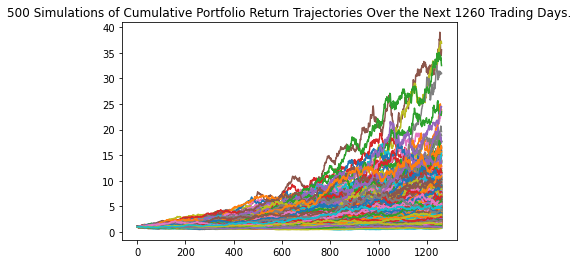

In [11]:
line_plot = MC_AMZN.plot_simulation()

*Save the plot for future usage*

In [12]:
line_plot.get_figure().savefig("MC_fiveyear_sim_plot.png", bbox_inches="tight")

*Plot probability distribution and confidence intervals*

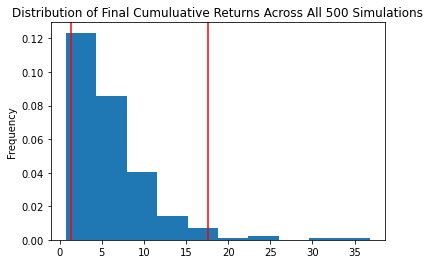

In [14]:
dist_plot = MC_AMZN.plot_distribution()

*Save the plot for future usage*

In [17]:
dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png',bbox_inches='tight')

*Fetch summary statistics from the Monte Carlo simulation results*

In [18]:
tbl = MC_AMZN.summarize_cumulative_return()

*Print summary statistics*

In [19]:
print(tbl)

count           500.000000
mean              6.108440
std               4.750296
min               0.722335
25%               3.015600
50%               4.827053
75%               7.768543
max              36.856924
95% CI Lower      1.283642
95% CI Upper     17.592259
Name: 1260, dtype: float64


*Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments in AMZN stocks*

In [20]:
ci_lower = round(tbl[8]*10000,2)
ci_upper = round(tbl[9]*10000,2)

*Print results*

In [21]:
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next year will end within in the range of"
      f" ${ci_lower} and ${ci_upper}.")

There is a 95% chance that an initial investment of $15,000 in the portfolio over the next year will end within in the range of $12836.42 and $175922.59.


*Compute summary statistics from the simulated daily returns*

In [22]:
simulated_returns_data = {
    'mean' : list(MC_AMZN.simulated_return.mean(axis=1)),
    'median' : list(MC_AMZN.simulated_return.median(axis=1)),
    'min' : list(MC_AMZN.simulated_return.min(axis=1)),
    'max' : list(MC_AMZN.simulated_return.max(axis=1))
}

*Create a DataFrame with the summary statistics*

In [23]:
df_simulated_returns = pd.DataFrame(simulated_returns_data)

*Display sample data*

In [24]:
df_simulated_returns.head()

,mean,median,min,max
0,1.000000,1.000000,1.000000,1.000000
1,1.000702,1.001452,0.950454,1.063779
2,1.000421,0.999860,0.922714,1.092285
3,1.001935,1.001870,0.908719,1.103170
4,1.002785,1.003954,0.908126,1.122570


*Use the `plot` function to visually analyze the trajectory of AMZN stock daily returns on a trading day simulation*

<AxesSubplot:title={'center':'Simulated Daily Returns Behavior of AMZN Stock Over the Next Year'}>

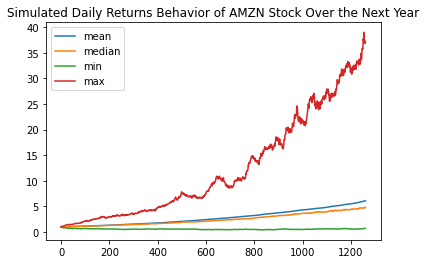

In [25]:
df_simulated_returns.plot(title="Simulated Daily Returns Behavior of AMZN Stock Over the Next Year")

*Set initial investment*

In [26]:
initial_investment = 15000

*Multiply an initial investment by the daily returns of simulative stock prices to return the progression of daily returns in terms of money*

In [27]:
cumulative_pnl = initial_investment * df_simulated_returns

*Display sample data*

In [28]:
cumulative_pnl.head()

,mean,median,min,max
0,15000.000000,15000.000000,15000.000000,15000.000000
1,15010.524814,15021.774394,14256.816841,15956.682485
2,15006.321520,14997.899051,13840.706272,16384.279568
3,15029.032210,15028.049395,13630.784372,16547.547577
4,15041.775713,15059.307387,13621.895581,16838.547591


*Use the 'plot' function to create a chart of the simulated profits/losses*

<AxesSubplot:title={'center':'Simulated Outcomes Behavior of AMZN Stock Over the Next Year'}>

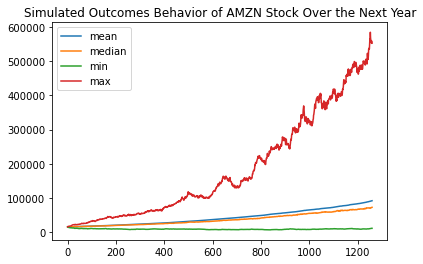

In [29]:
cumulative_pnl.plot(title="Simulated Outcomes Behavior of AMZN Stock Over the Next Year")